In [11]:
#################### DLPFC
###The raw data is download from http://spatial.libd.org/spatialLIBD
# load packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from scanpy import read_10x_h5
# load h5 file 
input_dir = "/h5file_store_path/151673"
section_id = '151673'
adata = sc.read_visium(path=input_dir, count_file=section_id+'_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()



In [12]:
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

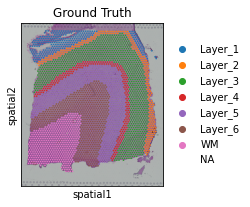

In [13]:
# step 1: select 3000 highly variable genes
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
# step 2: normalize each cell by total counts over all genes, so that every cell has the same total count after normalization
sc.pp.normalize_total(adata, target_sum=1e4)
# step 3: logarithmize the count matrix
sc.pp.log1p(adata)
# The true labels are extracted from data from R package 'spatialLIBD' and stored as “section_id_truth.txt”
Ann_df = pd.read_csv("/151673_truth.txt", sep='\t', header=None, index_col=0)

Ann_df.columns = ['Ground Truth']
# add 'Ground Truth' to adata
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']
# draw the ground truth plot of the sample
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"])
# save the processed adata to the path waiting for training
adata.write('/output_data/151676/151676.h5ad')

In [5]:
###########Stereo-seq mouse olfactory bulb
###The raw data is download from https://github.com/JinmiaoChenLab/SEDR_analyses/
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
# prepare counts file and coordinates file
counts_file = '/data_store_path/RNA_counts.tsv'
coor_file = '/data_store_path/position.tsv'

counts = pd.read_csv(counts_file, sep='\t', index_col=0)
coor_df = pd.read_csv(coor_file, sep='\t')
print(counts.shape, coor_df.shape)



(27106, 19527) (19527, 3)


In [6]:
# add column names and row indices
counts.columns = ['Spot_'+str(x) for x in counts.columns]
coor_df.index = coor_df['label'].map(lambda x: 'Spot_'+str(x))
coor_df = coor_df.loc[:, ['x','y']]

adata = sc.AnnData(counts.T)
adata.var_names_make_unique()

coor_df = coor_df.loc[adata.obs_names, ['y', 'x']]
adata.obsm["spatial"] = coor_df.to_numpy()
sc.pp.calculate_qc_metrics(adata, inplace=True)

# remove spots outside the main tissue area, using the file 
# https://drive.google.com/drive/folders/10lhz5VY7YfvHrtV40MwaqLmWz56U9eBP?usp=sharing.
used_barcode = pd.read_csv('/data_store_path/used_barcodes.txt', sep='\t', header=None)
used_barcode = used_barcode[0]
adata = adata[used_barcode,]
# filter genes
sc.pp.filter_genes(adata, min_cells=50)
adata



AnnData object with n_obs × n_vars = 19109 × 14376
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    obsm: 'spatial'

In [7]:
# Normalize the data
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
# save .h5ad file waiting for training
input_dir = 'input_Data_path'
section_id = 'Stereo-seq'
anndata_file = os.path.join(input_dir, section_id,section_id+'.h5ad')
adata.write(anndata_file)


In [ ]:
##############Stereo-seq embryo
# download name_bin1.tsv.gz file from https://db.cngb.org/stomics/mosta/download/, use convert_gem_to_gef.job to  convert it to .gef file
# After generating .gef file, use Stereo_seq_50.job to convert it to .h5ad file with bin size of 50.
# use  .h5ad file from above step as input directly. (no need to go through preprocessing steps in Stereo-seq mouse olfactory bulb)

In [8]:
###############Seq-scope
###The raw data is download from https://deepblue.lib.umich.edu/data/concern/data_sets/9c67wn05f
from scipy.io import mmread
import scanpy as sc
import pandas as pd
import os
input_dir = '/data_store_path/scope_colon'
# extract the spatial coordiantes and expression matrix from .rds file first.
# load coordinates and counts matrix
cor = pd.read_csv(os.path.join(input_dir, 'spatial.csv'))
a = mmread(os.path.join(input_dir, 'counts.mtx'))
A = a.tocsr()
# create adata
adata =sc.AnnData(A.T)
names = pd.read_csv(os.path.join(input_dir, 'varnames.csv'))
# add variable names for adata
adata.var_names = names['genes']

adata.var_names_make_unique()
adata


AnnData object with n_obs × n_vars = 28399 × 20423

In [9]:
# add spatial coordinates
adata.obsm["spatial"] = cor[['x','y']].to_numpy()
# filter genes
sc.pp.filter_genes(adata, min_cells=50)
print('After flitering: ', adata.shape)
# Normalize the data
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
# save .h5ad file waiting for training
adata.write(os.path.join(input_dir, 'scope_colon.h5ad'))


After flitering:  (28399, 15750)
